In [ ]:
 from julia import Julia
jl = Julia(sysimage = "/home/callum/ASF/Fitting/sys_model.so") #loading sys image

In [ ]:
import matplotlib.pyplot as plt

import os
import tempfile
import numpy as np
import scipy as sp

from scipy import stats
import random as rd
from brokenaxes import brokenaxes

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [137]:
plt.style.use('seaborn-colorblind')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [5]:
def read_inputs(path,number):
    
    models = [1,2,3,4]
    
    if number not in models:
        raise Exception("Model number must be 1, 2, 3 or 4") 
        
    weights = np.genfromtxt(path + "/h{}_weights.csv".format(number), delimiter=',')
    params = np.genfromtxt(path + "/h{}_params.csv".format(number), delimiter=',')
    
    nparams = params.shape[1]
    
    p1_dis = stats.gaussian_kde(params[:,0],weights = weights)
    p2_dis = stats.gaussian_kde(params[:,1],weights = weights)
    
    if nparams == 2:
        return p1_dis, p2_dis
    elif nparams == 3:
        p3_dis = stats.gaussian_kde(params[:,2],weights = weights)
        return p1_dis, p2_dis, p3_dis
    

In [6]:
def distance_from_mean(store):
    
    mean_ep = 1.5
    std_ep = 0.604

    mean_pd = 75
    std_pd = 6.08

    mean_mt = 180
    std_mt = 36.475

    
    store_t = (store -[mean_ep, mean_pd, mean_mt]) / ([std_ep, std_pd, std_mt])
    
    d = np.linalg.norm(store_t,axis=1)
    
    mean = np.mean(d)
    c_95 = np.percentile(d,[2.5, 97.5])
    
    print('Mean distance = ', mean)
    print('95% confidence interval =', c_95)
    
    return d, mean, c_95

In [7]:
def run_simulations_inter(path,number,n_sims, value, median = False):
    
    posteriors = read_inputs(path,number)
    
    n_params = len(posteriors) #two or three fitted parameters!
    
    dd = 0
    n_samples = 100000
    
    dp1 = posteriors[0].resample(n_samples)[0]
    dp2 = posteriors[1].resample(n_samples)[0]

    rd.shuffle(dp1)
    rd.shuffle(dp2)
    
    if n_params == 3:
        dp3 = posteriors[2].resample(n_samples)[0]
        rd.shuffle(dp3)
        
    if median:
        if n_params == 2:
            p = (np.median(dp1), np.median(dp2), value,number)
            
        elif n_params ==3:
             p = (np.median(dp1), np.median(dp2), np.median(dp3), value,number)
            
    for i in range(n_sims):
        
        if not median:
            if n_params == 2:
                p = (dp1[i], dp2[i], value,number)
            elif n_params ==3:
                p = (dp1[i], dp2[i], dp3[i], value,number)

        
        
        out = model_int(p)
        
        
        dd += out
  
    return dd


In [203]:
def simulate_intervention(mn,nsims,path, cs = [0]):
    if cs.all() == [0]:
        test_strengths = np.linspace(60,99,100)
    else:
        test_strengths = cs
    
    dummy  = np.zeros(len(test_strengths)) 
    for i, j in enumerate(test_strengths):

        wa = (100-j)/100

        val = run_simulations_inter(path,mn,nsims, wa)
        red = round(100*val/n_sims,3)
        dummy[i] = red
        
    return dummy

# ODE model

In [166]:
jl.eval('push!(LOAD_PATH, "/home/callum/ASF/Fitting/ODE_Extinct.jl")')
jl.include('/home/callum/ASF/Fitting/ODE_Extinct.jl') #loading files with our model!

#Loading the four models!
model_int = jl.SIR_ODE.model_int #Frequency


In [173]:
model_no = 1
n_sims = 1000

path = "/home/callum/ASF/Fitting/Posteriors/ODE/"


In [204]:
#ode1 = simulate_intervention(1,n_sims,path)
ode2 = simulate_intervention(2,n_sims,path, test_ode3)
ode3 = simulate_intervention(3,n_sims,path, test_ode3)
ode4 = simulate_intervention(4,n_sims,path, test_ode4)

In [316]:
test_strengths = np.linspace(60,97.5,100)

In [298]:
lo1 = np.load("/home/callum/lowerode1.npy")
lo2 = np.load("/home/callum/lowerode2.npy")
lo3 = np.load("/home/callum/lowerode3.npy")
lo4 = np.load("/home/callum/lowerode4.npy")

uo1 = np.load("/home/callum/upperode1.npy")
uo2 = np.load("/home/callum/upperode2.npy")
uo3 = np.load("/home/callum/upperode3.npy")
uo4 = np.load("/home/callum/upperode4.npy")

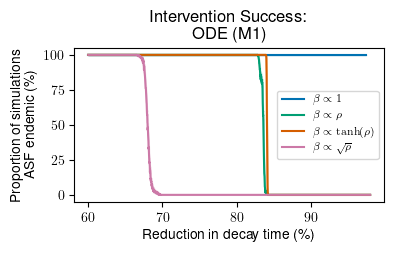

In [317]:
plt.figure(figsize = (4,2))


plt.plot(test_strengths,ode1, label = r"$\beta \propto 1$", color = colors[0]) 
plt.plot(test_ode3,ode2, label = r"$\beta \propto \rho$", color = colors[1]) 
plt.plot(test_ode3,ode3, label = r"$\beta \propto \tanh(\rho)$", color = colors[2]) 
plt.plot(test_ode4,ode4, label = r"$\beta \propto \sqrt \rho$", color = colors[3]) 
plt.title("Intervention Success:\n ODE (M1)")
plt.xlabel("Reduction in decay time (\%)")
plt.ylabel("Proportion of simulations\nASF endemic (\%)")
plt.legend(fontsize=8)

plt.fill_between(test_strengths, lo1*100, uo1*100, color=colors[0], alpha=0.25)
plt.fill_between(test_ode3, lo2*100, uo2*100, color=colors[1], alpha=0.25)

plt.fill_between(test_ode3, lo3*100, uo3*100,color=colors[2], alpha=0.25)
plt.fill_between(test_ode4, lo4*100, uo4*100,color=colors[3], alpha=0.25)




# TAU Homogeneous 

In [219]:
jl.eval('push!(LOAD_PATH, "/home/callum/ASF/Fitting/TAU_HOMO_EXTINCT.jl")')
jl.include('/home/callum/ASF/Fitting/TAU_HOMO_EXTINCT.jl') #loading files with our model!

#Loading the four models!
model_int = jl.SIR_TAU_S.model_int #Frequency

/home/callum/.local/lib/python3.10/site-packages/julia/core.py:709: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


In [311]:
#test_strengths = np.linspace(0.01,1.0,10)[::-1]
test_strengths = np.linspace(0,97.5,100)
#round(100-test_strengths*100,3)


In [271]:
model_no = 1
n_sims = 1000

path = "/home/callum/ASF/Fitting/Posteriors/Tau-Homogeneous/"


In [285]:
l1 = np.load("/home/callum/lower1.npy")
l4 = np.load("/home/callum/lower4.npy")

u1 = np.load("/home/callum/upper1.npy")
u4 = np.load("/home/callum/upper4.npy")



In [272]:
store_tau1 = np.zeros(len(test_strengths)) 
for i, j in enumerate(test_strengths):
    
    wa = (100-j)/100
    
    val = run_simulations_inter(path,model_no,n_sims, wa)
    red = round(100*val/n_sims,3)
    store_tau1[i] = red
    #print("Reduction: {}%".format(j))
    #print("Endemic: {}%".format(red))
    #print("--------------")
    
    #if red < 10:
     #   break

In [313]:
test_strengths = np.linspace(0,97.5,100)


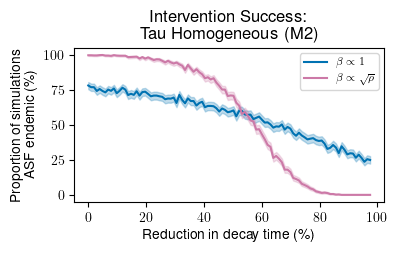

In [314]:
plt.figure(figsize = (4,2))

plt.plot(test_strengths,store_tau1, label = r"$\beta \propto 1$", color = colors[0]) 
plt.plot(test_strengths,store_tau4, label = r"$\beta \propto \sqrt \rho$", color = colors[3]) 
plt.title("Intervention Success:\nTau Homogeneous (M2)")
plt.xlabel("Reduction in decay time (\%)")
plt.ylabel("Proportion of simulations\nASF endemic (\%)")

plt.fill_between(test_strengths, l1*100, u1*100,
                 color=colors[0], alpha=0.25)

plt.fill_between(test_strengths, l4*100, u4*100,
                 color=colors[3], alpha=0.25)

plt.legend(fontsize=8)